In [1]:
import pprint
from sklearn.metrics import mean_absolute_error
from minepy import MINE
import numpy as np  # Run PTP simulation
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import allantools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import moment
from scipy.signal import decimate, resample
from scipy.spatial.distance import correlation as dist_corr
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Lambda
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/py

## Time series analysis
  [1] Define a weak stationary time series if the mean function $ E[x(t)] $ is independent of $ t $, if the autocoraviation function $Cov (x(t+h), x(t))$  is independent of $ t $ for each $h$ and if $E[x^2[n]]$ is finite for each $n$.
  
  To perform the weak stationary test, the mean function and the autocovariation function ware applied over rolling windows, since its sampled data. Thus, the window size has an impact over the functions interpretations, the window represents the interval in which the stationary hypothesis is tested.
  
  As a sanity check, the week stationary test will be applied over white noise data and random-walk data.[1] Proofs mathematically that white noise is stationary, and that random walk data is non-stationary, by the weak stationary definition.
  
  Besides this definition, the $ statsmodels $ library has the Augmented Dickey-Fuller unit root test.
  The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

  ### References
  [1] Brockwell, Peter J., and Richard A. Davis. Introduction to time series and forecasting. springer, 2016.

In [2]:
def stationary_test(entry,delta=200,ad=False,std=False):
    window_size=int(len(entry)/15)
    # Weak stationary test
    # Mean function
    mean_y = []
    mean_x = []
    
    s_moment_y = []
    std_y = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size)):
        # Roling window start and end
        n_start = i
        n_end = n_start + window_size
        # Mean, standard deviation and second moment calculation
        mean_y_i = np.mean(entry[n_start:n_end])
        s_moment_y_i = moment(entry[n_start:n_end],moment=2)
        std_y_i = np.std(entry[n_start:n_end])
        # Saving the results 
        mean_y.append(mean_y_i)
        mean_x.append(n_end)
        s_moment_y.append(s_moment_y_i)
        std_y.append(std_y_i)

    # Autocovariance function
    acov_y = []
    acov_x = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size - delta)):
        n_start = i
        n_end = n_start + window_size
        acov_y_i = np.cov(
            entry[n_start:n_end], entry[n_start+delta:n_end+delta]
        )[0][0]
        acov_y.append(acov_y_i)
        acov_x.append(n_end)
    if(ad):
        result = adfuller(entry)
        print("ADF Statistic: %f" % result[0])
        print("p-value: {0}".format(result[1]))
        print("Critical Values:")
        for key, value in result[4].items():
            print("\t%s: %.3f" % (key, value))
        # if the p-value < 0.05  and the adf statistic is less than
        # critical values the series is stationary or is time independent
        
    return [mean_x,mean_y],[acov_x,acov_y], s_moment_y, std_y
    


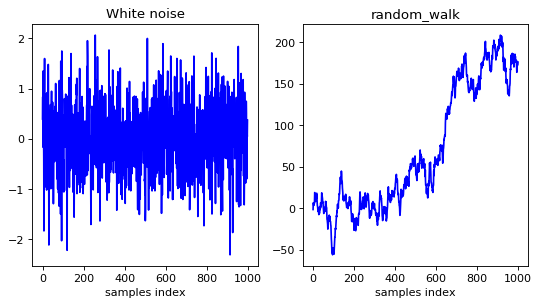

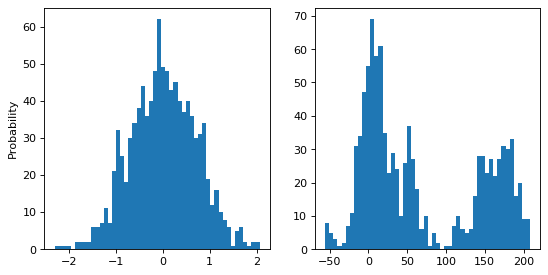

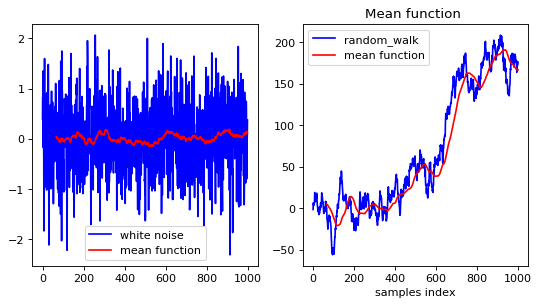

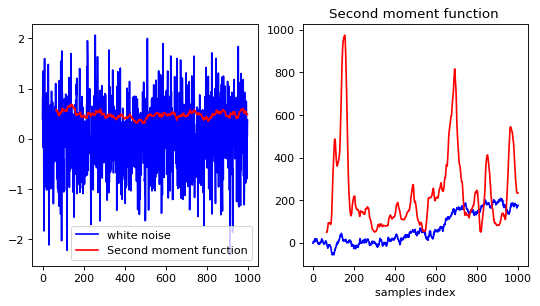

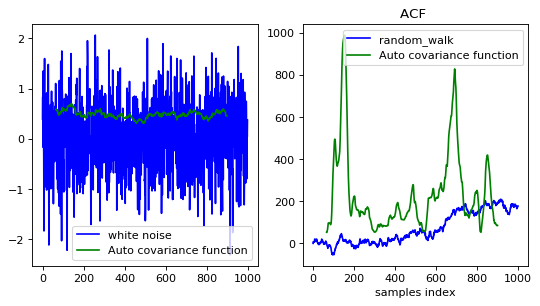

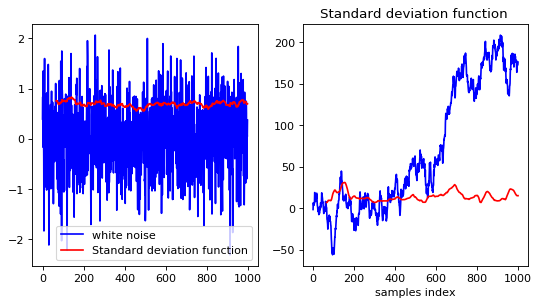

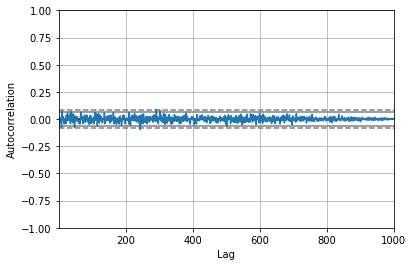

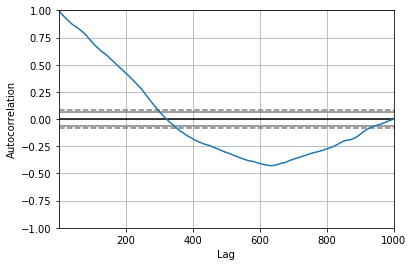

In [3]:
# White noise data 
white_noise = allantools.noise.white(1000)
random_walk = allantools.noise.brown(1000)

# To help us  visualise the constance in the cov plot lets first scale the entry
white_noise = white_noise#/(np.amax(white_noise))
random_walk = random_walk#/np.amax(np.abs(random_walk))
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(white_noise, "b", label="white noise")
plt.xlabel("samples index")
plt.title("White noise")
plt.subplot(122)
plt.plot(random_walk, "b", label="random_walk")
plt.xlabel("samples index")
plt.title("random_walk")
plt.show()

plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.ylabel("Probability")
plt.hist(white_noise, 50)
plt.subplot(122)
plt.hist(random_walk, 50)
plt.show()

mean_w, cov_w, s_moment_w, std_w = stationary_test(white_noise,delta=100,ad=False)
mean_r, cov_r, s_moment_r, std_r = stationary_test(random_walk,delta=100,ad=False)

plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(white_noise, "b", label="white noise")
plt.plot(mean_w[0],mean_w[1], "r", label="mean function")
plt.legend()
plt.subplot(122)
plt.plot(random_walk, "b", label="random_walk")
plt.plot(mean_r[0],mean_r[1], "r", label="mean function")
plt.legend()
plt.xlabel("samples index")
plt.title("Mean function ")
plt.show()

plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(white_noise, "b", label="white noise")
plt.plot(mean_w[0],s_moment_w, "r", label="Second moment function")
plt.legend()
plt.subplot(122)
plt.plot(random_walk, "b", label="random_walk")
plt.plot(mean_r[0],s_moment_r, "r", label="Second moment function")
plt.xlabel("samples index")
plt.title("Second moment function ")
plt.show()

plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(white_noise, "b", label="white noise")
plt.plot(cov_w[0],cov_w[1], "g", label="Auto covariance function")
plt.legend()
plt.subplot(122)
plt.plot(random_walk, "b", label="random_walk")
plt.plot(cov_r[0],cov_r[1], "g", label="Auto covariance function")
plt.xlabel("samples index")
plt.title("ACF ")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(white_noise, "b", label="white noise")
plt.plot(mean_w[0],std_w, "r", label="Standard deviation function")
plt.legend()
plt.subplot(122)
plt.plot(random_walk, "b", label="random_walk")
plt.plot(mean_r[0],std_r, "r", label="Standard deviation function")
plt.xlabel("samples index")
plt.title("Standard deviation function ")
plt.show()

# White noise
plt.figure
pd.plotting.autocorrelation_plot(white_noise)
plt.show()

# random walk
plt.figure
pd.plotting.autocorrelation_plot(random_walk)
plt.show()

### Sanity test analysis
The test showed that the white noise presents a mean, covariance, standard deviation functions close to a constant in time, on the other hand, the random walk presents the same functions varying in time. Thus, by the functions presented here, the white noise is stationary, and the random walk is non-stationary, note that we are analyzing one realization of those random process, hence with the frequency offset data we will have also only 1 realization to test if the data is either stationary or not.

Besides that, the autocorrelation function on the random walk shows a slow decaying behavior and for several lags, the ACF presents values above the confidence interval. Thus, the ACF is another indication of the random walk non-stationary behavior.
The ACF applied on the white noise function presents, on almost every lag, values bellow the confidence lines. Hence, the white noise ACF shows an indication of the white noise stationarity. 

## Importing time series data

In [4]:
# Importing Data
data_csv = "bova11.csv"
dataframe = pd.read_csv(data_csv)
data = dataframe.values
price  = data[:,1]
open_p = data[:,2]
high   = data[:,3]
low    = data[:,4]
volume = data[:,5]
price = np.array(price,dtype=float)
open_p = np.array(open_p,dtype=float)
high   = np.array(high,dtype=float)
low    = np.array(low,dtype=float)
volume = np.array(volume,dtype=float)

pprint.pprint(dataframe)

                     Date   Close    Open    High     Low   Volume
0      12/6/2010 16:56:00   68.60   69.00   69.15   68.59   134030
1      12/7/2010 16:56:00   68.80   69.50   69.82   68.76   285930
2      12/8/2010 16:56:00   67.35   68.80   69.29   67.33   403570
3      12/9/2010 16:56:00   67.22   67.52   67.84   66.84   261250
4     12/10/2010 16:56:00   67.89   67.60   67.89   67.18   269140
...                   ...     ...     ...     ...     ...      ...
2159  11/25/2019 16:56:00  104.25  104.79  104.87  104.06  2800260
2160  11/26/2019 16:56:00  103.44  104.13  104.13  102.46  7627410
2161  11/27/2019 16:56:00  103.68  103.30  104.00  102.29  3266080
2162  11/28/2019 16:56:00  104.38  103.46  104.38  103.20  2597560
2163  11/29/2019 16:56:00  104.35  104.38  104.70  103.70  2358810

[2164 rows x 6 columns]


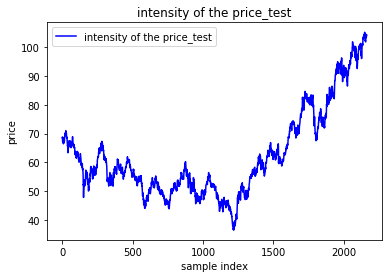

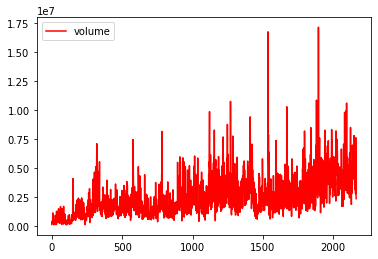

In [5]:
plt.figure()
plt.plot(price, "b", label="intensity of the price_test")
plt.ylabel("price")
plt.xlabel("sample index")
plt.title("intensity of the price_test")
plt.legend()
plt.show()

plt.figure()
plt.plot(volume, "r", label="volume")
plt.legend()
plt.show()

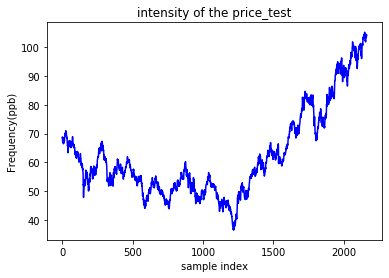

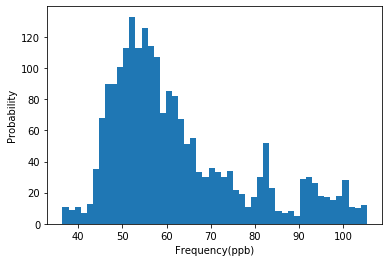

ADF Statistic: 0.020375
p-value: 0.9601849668179928
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


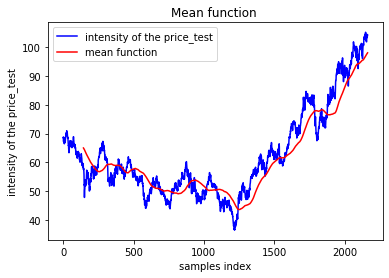

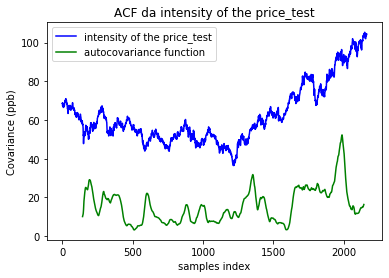

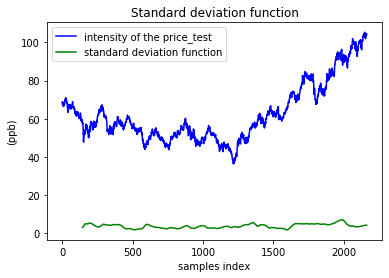

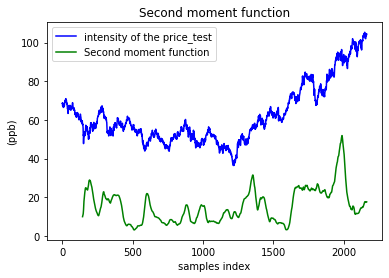

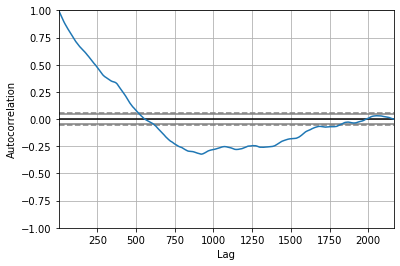

In [6]:
# Check if the original time series is stationary or not
price_test = np.array(price,dtype=float)
df_log = pd.DataFrame(price_test)
win_size = int(len(price_test)/15)

# Normalize the intensity of the price_test data
norm_wind =  np.array(price_test)

plt.figure()
plt.plot(price_test, "b", label="intensity of the price_test")
plt.ylabel("Frequency(ppb)")
plt.xlabel("sample index")
plt.title("intensity of the price_test")
plt.show()

plt.figure()
plt.hist(price_test, 50)
plt.ylabel("Probability")
plt.xlabel("Frequency(ppb)")
plt.show()

# Weak stationary test
mean, cov, s_moment, std = stationary_test(norm_wind,delta=20,ad=True) 

plt.figure()
plt.plot(norm_wind, "b", label="intensity of the price_test")
plt.plot(mean[0], mean[1], "r", label="mean function")
plt.xlabel("samples index")
plt.ylabel("intensity of the price_test")
plt.title("Mean function ")
plt.legend()
plt.show()

plt.figure()
plt.plot(norm_wind, "b", label="intensity of the price_test")
plt.plot(cov[0], cov[1], "g", label="autocovariance function")
plt.xlabel("samples index")
plt.ylabel("Covariance (ppb)")
plt.title("ACF da intensity of the price_test")
plt.legend()
plt.show()

plt.figure()
plt.plot(norm_wind, "b", label="intensity of the price_test")
plt.plot(mean[0], std, "g", label="standard deviation function")
plt.xlabel("samples index")
plt.ylabel("(ppb)")
plt.title("Standard deviation function")
plt.legend()
plt.show()

plt.figure()
plt.plot(norm_wind, "b", label="intensity of the price_test")
plt.plot(mean[0], s_moment, "g", label="Second moment function")
plt.xlabel("samples index")
plt.ylabel("(ppb)")
plt.title("Second moment function")
plt.legend()
plt.show()

# Autocorrelation function
# If intensity of the price_test is non stationary the autocorrelation plot will show periodic behavior
plt.figure()
pd.plotting.autocorrelation_plot(norm_wind)
plt.show()

# Based on the autocorrelation plot, is correct to infer that
# the data has a strong seasonality based on the sinusoidal
# behavior on the autocorrelation plot.
# The intensity of the price_test period is next to 1140 samples


  ### Analyzing the test results
  The mean function test hypothesis failed, this can be noted by checking the 
function follows the trend of the frequency offset, the covariation function presents a linear behavior with some disturbance, the standard deviation function seans to be linear like, but with a lot of noise.
The second-moment function doesn't show a tendency to infinite on any $n$, that way passing on this condition. 

Analyzing the functions plots it's correct to infer that this realization of the frequency offset is non-stationary, this can be also noted on the autocorrelation plot, which shows a slow decaying behavior.the autocorrelation plot shows also a periodic behavior, which represents a periodic behavior on the time series, and also in several lags the ACF value goes above and bellow the confidence intervals of 99% and 95%

   ### The FFT of frequency offset could be usefull to get its harmonics components
   The previous tests showed that this time series present a seasonal component, through FFT we can analyse the peaks and find out it's frequency and period.

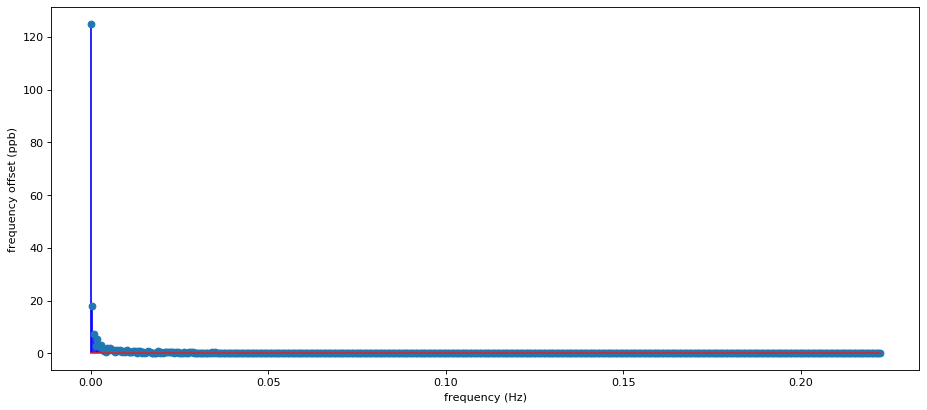

In [7]:
y_fft = np.fft.fft(price)
y_fft_freq = np.fft.fftfreq(len(price), d=1)
spectrum_magnitude = abs(y_fft) * (2 / len(price))
end = int(len(y_fft) / 2) - 600
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.stem(y_fft_freq[:end], spectrum_magnitude[:end], "b", use_line_collection=True)
plt.xlabel("frequency (Hz)")
plt.ylabel("frequency offset (ppb)")
plt.show()

# The FFT plot shows that the  frequency offset data has a spike on
# frequency = 0.0008679 1/samples which give us the period of 1152 samples


   ## If the original time series still non-stationary a method is necessary to turn the time series stationary
   Consider $x[n]$ as a time series, if it is non-stationary it can be divided in a seasonal, trend and a residual component.
   $$ x[n] = s[n] + m[n] + Y[n] $$

  Where $s[n]$,$m[n]$ and $Y[n]$ are respectively the seasonal, trend and residual components. The seasonal component is a function with period $d$, the trend component is a slowly changing function, the residual component is a random  noise function stationary, based on the weak stationary definition.

  There are few ways to remove the trend and seasonal components, the principal ones are by estimating the $m[n]$ and $s[n]$ components, and the other one is by differencing the time series.

  One way to estimate the $m[n]$ component is to apply a moving average of the time series, to remove the seasonal component a polynomial least-square regression could be done to fit a trend, then subtract the time series by fited trend.

  ### Lets first analyse the differencing procedure
   #### Differencing  a signal and invert differencing
   1. Consider a time series $x[n]$ and a lag $p$, in order of obtaining the stationary form of the time series :

   $$ diff[n] = x[n] - x[n -p] $$
   2. Note that this process is reversible, but not to the entire length of the original $ x[n]$ time series array, is not reversible only for the first $p$ samples, that way the inverted difference array will have the length: $length(x) - p $

   3. To invert the difference, the $diff[n]$ data must be added to the lagged $x[n]$ :

   $$ x[n] = diff[n] + x[n-p]$$

   4. The difference is a seasonal difference if $p$ is equal to $x[n]$ period


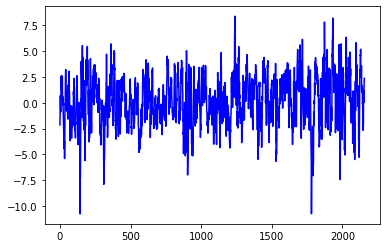

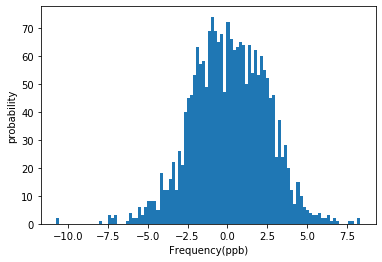

ADF Statistic: -6.939179
p-value: 1.0356903505267381e-09
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


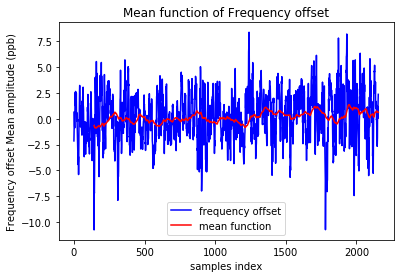

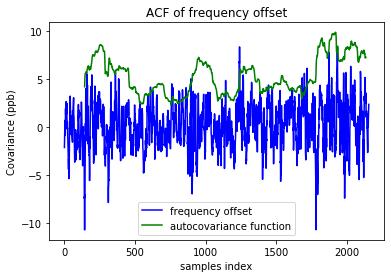

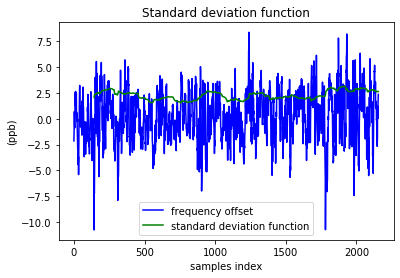

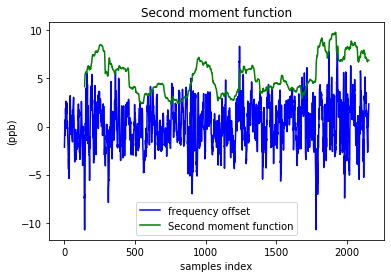

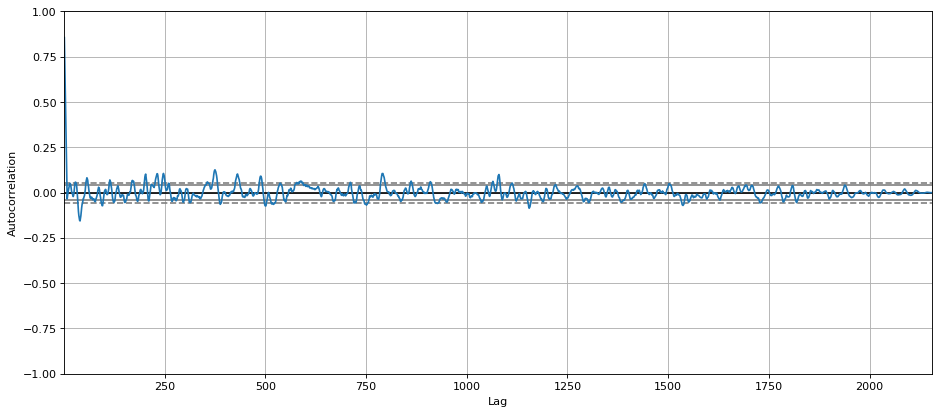

In [8]:
# With the period, a seasonal differentiation could be applied
lag = 8
price_test = price
price_test = np.array(price_test[lag:]) - np.array(price_test[:-lag])

norm_diff_freq = price_test#/np.amax(price_test)
plt.figure()
plt.plot(price_test, "b", label="frequency")
plt.show()

plt.figure()
plt.hist(price_test, 100)
plt.ylabel("probability")
plt.xlabel("Frequency(ppb)")
plt.show()

# Weak stationary test
mean, cov, s_moment, std = stationary_test(norm_diff_freq,delta=20,ad=True) 

plt.figure()
plt.plot(norm_diff_freq, "b", label="frequency offset")
plt.plot(mean[0], mean[1], "r", label="mean function")
plt.xlabel("samples index")
plt.ylabel("Frequency offset Mean amplitude (ppb)")
plt.title("Mean function of Frequency offset")
plt.legend()
plt.show()

plt.figure()
plt.plot(norm_diff_freq, "b", label="frequency offset")
plt.plot(cov[0], cov[1], "g", label="autocovariance function")
plt.xlabel("samples index")
plt.ylabel("Covariance (ppb)")
plt.title("ACF of frequency offset")
plt.legend()
plt.show()

plt.figure()
plt.plot(norm_diff_freq, "b", label="frequency offset")
plt.plot(mean[0], std, "g", label="standard deviation function")
plt.xlabel("samples index")
plt.ylabel("(ppb)")
plt.title("Standard deviation function")
plt.legend()
plt.show()

plt.figure()
plt.plot(norm_diff_freq, "b", label="frequency offset")
plt.plot(mean[0], s_moment, "g", label="Second moment function")
plt.xlabel("samples index")
plt.ylabel("(ppb)")
plt.title("Second moment function")
plt.legend()
plt.show()

# Autocorrelation function
# If frequency offset is non stationary the autocorrelation plot will show periodic behavior
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
# pd.plotting.autocorrelation_plot(norm_diff_freq)
pd.plotting.autocorrelation_plot(norm_diff_freq)
plt.show()


# Based on the autocorrelation plot, is correct to infer that
# the data has a strong seasonality based on the sinusoidal
# behavior on the autocorrelation plot.
# The frequency offset period is next to 1140 samples


## Analysing the test results on the differencied form of frequency offset
The mean function is more linear than the original data, but still has strong trends. The standard deviation and covariance function also presents a linear behavior, but with a lot of noise. The autocovariance function rapdly decain behavior, with no more representative seasonal trend.

From the functions plots its correct to infer that the difference of the data, using a $p$ of the infered deterministic period, is non-stationary yet. The differencied form of the frequency offset data shows more stationary behavior, but still non-stationary.

   ### The FFT of diff frequency offset could be usefull to get its harmonics components
   The previous tests showed that this time series present a seasonal component, through FFT we can analyse the peaks and find out it's frequency and period.

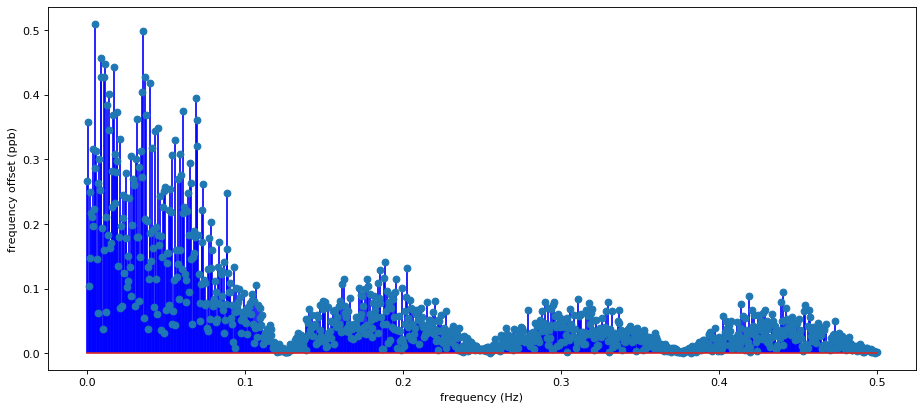

In [9]:
y_fft = np.fft.fft(price_test)
y_fft_freq = np.fft.fftfreq(len(price_test), d=1)
spectrum_magnitude = abs(y_fft) * (2 / len(price_test))
end = int(len(y_fft) / 2) 
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.stem(y_fft_freq[:end], spectrum_magnitude[:end], "b", use_line_collection=True)
plt.xlabel("frequency (Hz)")
plt.ylabel("frequency offset (ppb)")
plt.show()


In [10]:
def print_stats(mine):
    print ("MIC", mine.mic())
    print ("MAS", mine.mas())
    print ("MEV", mine.mev())
    print ("MCN (eps=0)", mine.mcn(0))
    print ("MCN (eps=1-MIC)", mine.mcn_general())
    print ("GMIC", mine.gmic())
    print ("TIC", mine.tic())

### Analyzing the results
Using the Pearson correlation coefficient perhaps doesn't represent a possible non-linear relationship between temperature and frequency offset data. Another coefficient to estimate possible non-linear relationship is the Maximal information coeficient[2], this coefficient calculates the mutual information between 2 arrays.

By looking at the results using the moving average to smooth the noise on temperature data, it is correct to infer that the moving average of temperature would be a better feature than the raw temperature data.

### References
[2] https://minepy.readthedocs.io/en/latest/index.html

### Number of features lags to use
As the temperature and frequency offset data are time-series select 

In [11]:
# Lag matrix
# Check the autocorrelation matrix
# Generating the autocorrelation to each lag
price = np.array(price).flatten()
volume = np.array(volume,dtype=float).flatten()
lag = 8
price_test  = np.array(price[lag:]) - np.array(price[:-lag])
volume_test = np.array(volume[lag:]) - np.array(volume[:-lag])
x = np.array(price[lag:]) - np.array(price[:-lag])
x1 = volume_test
lag = np.arange(1,100,1)
start = lag[-1]
end = len(x)
R = [x[start - i : end - i] for i in lag]
R1 = [x1[start - i : end - i] for i in lag]
R2 = [R1[0] for i in lag]
r = np.corrcoef(R1,R)
corr = np.abs(r[0][len(lag):])
print("Absolute  cross correlation is bigger than 0.7 for the lags:")
print(np.where(corr > 0.5))

temp_dist_corr = np.array([dist_corr(i[0],i[1])/2 for i in zip(R2,R)])
print(np.where(temp_dist_corr > 0.5))

Absolute  cross correlation is bigger than 0.7 for the lags:
(array([], dtype=int64),)
(array([ 0,  1,  2,  3, 22, 30, 31, 32, 33, 34, 35, 36, 37, 38, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 81, 82, 83, 84, 85, 86, 91, 92, 93,
       94, 95, 96, 97, 98]),)


In [12]:
# Mutual information
mine = MINE(alpha=0.6, c=15, est="mic_approx")
mine.compute_score(price_test,volume_test)
print_stats(mine)

MIC 0.10916544047917359
MAS 0.008250959444977585
MEV 0.10916544047917359
MCN (eps=0) 6.643856189774725
MCN (eps=1-MIC) 2.0
GMIC 0.061967679267500256
TIC 12.139662658463212


In [13]:
print(corr)

[0.10316596 0.05356908 0.02139097 0.01713097 0.01429274 0.03304896
 0.03125917 0.04121791 0.07057653 0.05455633 0.03437575 0.04912734
 0.04246406 0.03809278 0.06300492 0.05677127 0.03074154 0.0389289
 0.02990304 0.00326148 0.00935121 0.01410344 0.0078876  0.00254379
 0.02201772 0.00689354 0.01407629 0.0173403  0.0009611  0.00019846
 0.0048005  0.02911263 0.03104789 0.02749254 0.03013567 0.04138822
 0.03878501 0.03966379 0.01811029 0.01054498 0.00917626 0.01480486
 0.01265919 0.04287929 0.04009902 0.02274125 0.00322075 0.01865249
 0.02854466 0.04503808 0.05658178 0.07926815 0.07603483 0.05054497
 0.04262237 0.03996833 0.03020447 0.01094896 0.02622338 0.03783208
 0.04340542 0.02515249 0.02247177 0.03637395 0.037923   0.02859444
 0.01127475 0.00974575 0.01360263 0.03063192 0.02586137 0.02670426
 0.02828518 0.04897062 0.054229   0.04573538 0.03663431 0.02583885
 0.03436058 0.01565267 0.01110742 0.01475074 0.02857733 0.00956071
 0.00621645 0.01487586 0.01318437 0.00430914 0.00265075 0.01300

In [28]:
N = 10
lag = 8
price_test = np.array(price[lag:]) - np.array(price[:-lag])
open_test  = np.array(open_p[lag:]) - np.array(open_p[:-lag])
low_test   = np.array(low[lag:]) - np.array(low[:-lag])
high_test  = np.array(high[lag:]) - np.array(high[:-lag])

volume_test = volume[lag:]
original_series = np.array(price[:-lag])
n_windows = len(price_test) - N

feature_mtx = np.zeros((n_windows, int(N*5)))
label_mtx = np.zeros((n_windows, 1))
feature_lstm = list[]
for i in range(0, n_windows):
    # Window start and end indexes
    i_s = i
    i_e = i + N
    # price data
    price_i = np.array(price_test[i_s : i_e])
    # open price
    open_i = np.array(open_test[i_s : i_e])
    # low price
    low_i = np.array(low_test[i_s : i_e])
    # high price
    high_i = np.array(high_test[i_s : i_e])
    # volume data
    volume_i = np.array(volume_test[i_s : i_e])
    volume_i = volume_i *np.amax(price_i)/np.amax(volume_i)
    feature_lstm_i = []
    for j in range(0,N):
        feature_lstm_j
    #Features array
    features = price_i
    features = np.concatenate((features,volume_i))
    features = np.concatenate((features,open_i))
    features = np.concatenate((features,low_i))
    features = np.concatenate((features,high_i))
    
    # Label: the first freq. offset of the next window, so that the NN is trained to predict
    label = price_test[i_e]
    # Save
    feature_mtx[i, :] = features
    label_mtx[i, :] = label


# Split
x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(
    feature_mtx,
    label_mtx,
    np.arange(0, n_windows),
    test_size=0.2,
    shuffle=False,
    random_state=42,
)

# # Split
# x_train, x_val, y_train, y_val, i_train, i_val = train_test_split(
#     x_train,
#     y_train,
#     i_train,
#     test_size=0.25,
#     shuffle=False,
#     random_state=42,
# )
# Shuffle post split data
#x_train, y_train, i_train = shuffle(x_train, y_train, i_train, random_state=42)

# Normalization gains based on training data
#
# NOTE: feature_mtx is (m x n_x), where m is the no. of training
# samples. Namely, features are along x axis (columns).
# Compute the maximum of each column and normalize using that.
# Normalize the datasets
min = np.min(x_train)
max = np.max(x_train)

x_train = (x_train - min) / (max - min)
x_test = (x_test - min)/(max - min)

Text(0, 0.5, 'ppb')

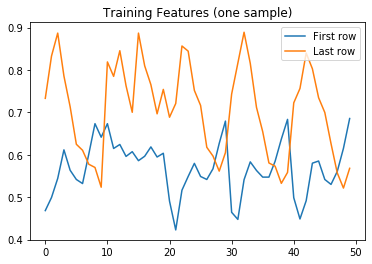

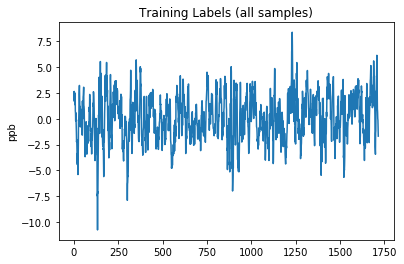

In [29]:
plt.figure()
plt.plot(x_train[0, :], label="First row")
plt.plot(x_train[-1, :], label="Last row")
plt.title("Training Features (one sample)")
plt.legend()

plt.figure()
plt.plot(y_train)
plt.title("Training Labels (all samples)")
plt.ylabel("ppb")

In [30]:
H1 = 100
H2 = 100
n_epochs = 1500
lr = 0.001  # learning rate
lr_decay = 0.01  # learning rate decay
n_mini_batch = 100  # mini-batch length
activation_fcn = "tanh"
optimizer = Adam(lr=lr, decay=lr_decay)

model = Sequential()
model.add(
    Dense(input_dim=(x_train.shape[1]), units=H1, activation=activation_fcn)
)
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
model.add(Dense(units=H2, activation=activation_fcn))
model.add(Dropout(0.2))
# model.add(Dense(units=H2, activation=activation_fcn))
# model.add(Dropout(0.2))
model.add(Dense(1, activation="linear"))
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=n_mini_batch,
    epochs=n_epochs,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", min_delta=0.01, patience=100, verbose=1
        )
    ],
)
model.save("model.h1")

Train on 1372 samples, validate on 344 samples
Epoch 1/1500
1372/1372 [==============================] - 1s 420us/step - loss: 4.5679 - val_loss: 3.9692
Epoch 2/1500
1372/1372 [==============================] - 0s 52us/step - loss: 3.2843 - val_loss: 4.4836
Epoch 3/1500
1372/1372 [==============================] - 0s 57us/step - loss: 2.6377 - val_loss: 2.3099
Epoch 4/1500
1372/1372 [==============================] - 0s 44us/step - loss: 2.4104 - val_loss: 1.9143
Epoch 5/1500
1372/1372 [==============================] - 0s 42us/step - loss: 2.0130 - val_loss: 1.7495
Epoch 6/1500
1372/1372 [==============================] - 0s 44us/step - loss: 2.0386 - val_loss: 1.6446
Epoch 7/1500
1372/1372 [==============================] - 0s 45us/step - loss: 1.7365 - val_loss: 1.6419
Epoch 8/1500
1372/1372 [==============================] - 0s 39us/step - loss: 1.6552 - val_loss: 1.7267
Epoch 9/1500
1372/1372 [==============================] - 0s 55us/step - loss: 1.6234 - val_loss: 1.4763
Epoch 1

Epoch 78/1500
1372/1372 [==============================] - 0s 58us/step - loss: 1.1125 - val_loss: 1.1293
Epoch 79/1500
1372/1372 [==============================] - 0s 41us/step - loss: 1.1127 - val_loss: 1.1290
Epoch 80/1500
1372/1372 [==============================] - 0s 45us/step - loss: 1.1489 - val_loss: 1.1243
Epoch 81/1500
1372/1372 [==============================] - 0s 42us/step - loss: 1.1920 - val_loss: 1.1300
Epoch 82/1500
1372/1372 [==============================] - 0s 59us/step - loss: 1.1231 - val_loss: 1.1282
Epoch 83/1500
1372/1372 [==============================] - 0s 36us/step - loss: 1.1445 - val_loss: 1.1276
Epoch 84/1500
1372/1372 [==============================] - 0s 32us/step - loss: 1.1285 - val_loss: 1.1321
Epoch 85/1500
1372/1372 [==============================] - 0s 39us/step - loss: 1.1689 - val_loss: 1.1287
Epoch 86/1500
1372/1372 [==============================] - 0s 42us/step - loss: 1.1309 - val_loss: 1.1229
Epoch 87/1500
1372/1372 [=====================

Epoch 155/1500
1372/1372 [==============================] - 0s 51us/step - loss: 1.0776 - val_loss: 1.1071
Epoch 156/1500
1372/1372 [==============================] - 0s 50us/step - loss: 1.0781 - val_loss: 1.1006
Epoch 157/1500
1372/1372 [==============================] - 0s 51us/step - loss: 1.1009 - val_loss: 1.1206
Epoch 158/1500
1372/1372 [==============================] - 0s 55us/step - loss: 1.1068 - val_loss: 1.0965
Epoch 159/1500
1372/1372 [==============================] - 0s 52us/step - loss: 1.0649 - val_loss: 1.1086
Epoch 160/1500
1372/1372 [==============================] - 0s 48us/step - loss: 1.1059 - val_loss: 1.1039
Epoch 161/1500
1372/1372 [==============================] - 0s 51us/step - loss: 1.0677 - val_loss: 1.1068
Epoch 162/1500
1372/1372 [==============================] - 0s 44us/step - loss: 1.0794 - val_loss: 1.1256
Epoch 163/1500
1372/1372 [==============================] - 0s 57us/step - loss: 1.0496 - val_loss: 1.1660
Epoch 164/1500
1372/1372 [===========

1372/1372 [==============================] - 0s 44us/step - loss: 1.0951 - val_loss: 1.1100
Epoch 232/1500
1372/1372 [==============================] - 0s 47us/step - loss: 1.0655 - val_loss: 1.1212
Epoch 233/1500
1372/1372 [==============================] - 0s 53us/step - loss: 1.0774 - val_loss: 1.0953
Epoch 234/1500
1372/1372 [==============================] - 0s 49us/step - loss: 1.0837 - val_loss: 1.0959
Epoch 235/1500
1372/1372 [==============================] - 0s 54us/step - loss: 1.0990 - val_loss: 1.0964
Epoch 236/1500
1372/1372 [==============================] - 0s 56us/step - loss: 1.0612 - val_loss: 1.1114
Epoch 237/1500
1372/1372 [==============================] - 0s 51us/step - loss: 1.0786 - val_loss: 1.1012
Epoch 238/1500
1372/1372 [==============================] - 0s 56us/step - loss: 1.0961 - val_loss: 1.0962
Epoch 239/1500
1372/1372 [==============================] - 0s 52us/step - loss: 1.0421 - val_loss: 1.0963
Epoch 240/1500
1372/1372 [==========================

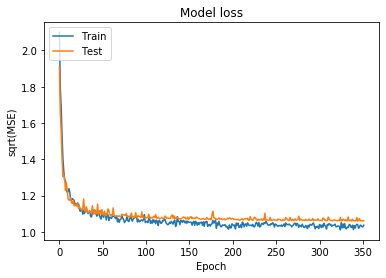

In [17]:
# Plot training & validation loss values
plt.figure()
plt.plot(np.sqrt(history.history["loss"]))
plt.plot(np.sqrt(history.history["val_loss"]))
plt.title("Model loss")
plt.ylabel("sqrt(MSE)")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")

In [33]:
time_dimension = False
if(time_dimension):
    xh_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    yh_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))
    xh_test  = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
else:
    xh_train = np.reshape(x_train, (x_train.shape[0],1 ,x_train.shape[1]))
    yh_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))
    xh_test  = np.reshape(x_test, (x_test.shape[0],1 ,x_test.shape[1]))

print(xh_train.shape)
holdover = Sequential()
# LSTM parameters
H1             = 100
H2             = 100
n_epochs       = 200
lr             = 0.001 # learning rate
lr_decay       = 0.001    # learning rate decay
n_mini_batch   = 64 # mini-batch length

# Input layer
holdover.add(LSTM(units=H1,return_sequences=True,input_shape=(xh_train.shape[1], xh_train.shape[2])))

# Hidden layers
holdover.add(LSTM(units=H2, return_sequences=True))
holdover.add(Dropout(0.2))
holdover.add(LSTM(units=H2, return_sequences=True))
holdover.add(Dropout(0.2))
holdover.add(LSTM(units=H2, return_sequences=True))
holdover.add(Dropout(0.2))
holdover.add(LSTM(units=H2, return_sequences=True))
holdover.add(Dropout(0.2))
holdover.add(LSTM(units=H2))

# Output layer
holdover.add(Dense(1))

holdover.compile(loss='mse', optimizer=Adam(lr=lr, decay=lr_decay))
history = holdover.fit(xh_train, yh_train,
                    validation_split=0.1,
                    batch_size=n_mini_batch,
                    epochs=n_epochs,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                            mode='min',
                                            min_delta=1,
                                            patience = 2,
                                            verbose=1)])

(1716, 1, 50)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1544 samples, validate on 172 samples
Epoch 1/200
1544/1544 [==============================] - 5s 3ms/step - loss: 4.8728 - val_loss: 5.2055
Epoch 2/200
1544/1544 [==============================] - 0s 291us/step - loss: 4.8693 - val_loss: 5.1175
Epoch 3/200
1544/1544 [==============================] - 0s 293us/step - loss: 4.3433 - val_loss: 2.7914
Epoch 4/200
1544/1544 [==============================] - 0s 291us/step - loss: 3.0041 - val_loss: 2.1268
Epoch 5/200
1544/1544 [==============================] - 0s 297us/step - loss: 2.5176 - val_loss: 1.9367
Epoch 00005: early stopping


Text(0, 0.5, 'ppb')

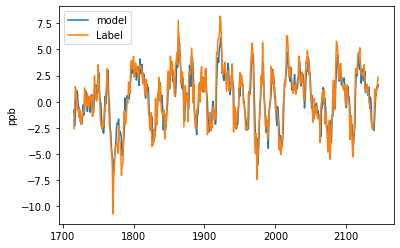

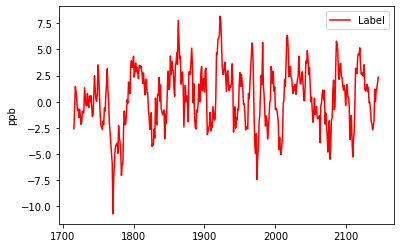

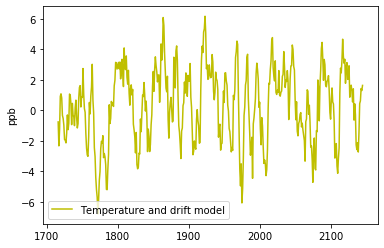

In [18]:
# Test some predictions
y_nn = model.predict(x_test)
y_nn = y_nn.flatten()
n_pred = len(y_nn)

plt.figure()
plt.plot(i_test, y_nn, label="model")
plt.plot(i_test, y_test.flatten(), label="Label")
plt.legend()
plt.ylabel("ppb")

plt.figure()
plt.plot(i_test, y_test.flatten(),'r' ,label="Label")
plt.legend()
plt.ylabel("ppb")

plt.figure()
plt.plot(i_test, y_nn, 'y',label="Temperature and drift model")
plt.legend()
plt.ylabel("ppb")

[NN TEMP] Variance:   1.77 Mean:  -0.06
[NN TEMP] MAE:       1.040190 


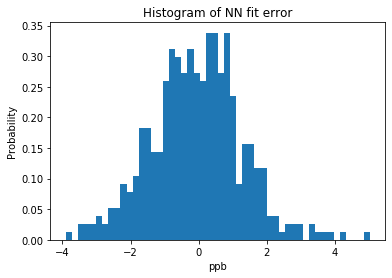

In [19]:
y_nn_temp_err = y_nn - y_test.flatten()

print(
    "[NN TEMP] Variance: %6.2f Mean: %6.2f"
    % (np.var(y_nn_temp_err), np.mean(y_nn_temp_err))
)
print("[NN TEMP] MAE:       %f " % mean_absolute_error(y_nn, y_test))

plt.figure()
plt.hist(y_nn_temp_err, bins=50, density=True)
plt.title("Histogram of NN fit error")
plt.xlabel("ppb")
plt.ylabel("Probability")

plt.show()

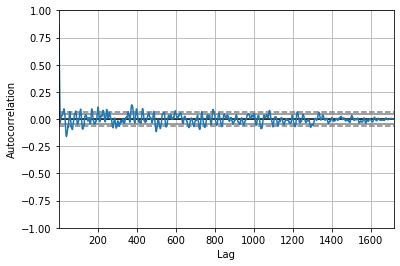

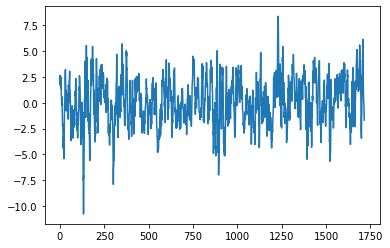

In [20]:
# ARIMA 
# The holdover approach is currently a univariate timeseries
# For this purpose the ARIMA model performs well
# Split

# y_train, y_test = train_test_split(
#     wind,
#     test_size=0.4,
#     shuffle=False,
#     random_state=42,
# )

# train data autocorrelation to find the d parameter
p_order    = 5
d_order    = 0 # Differencing order
q_order    = 0

if d_order > 0:
    train_diff = np.array(y_train[d_order:]) - np.array(y_train[:-d_order])
else:
    train_diff = y_train


fig = plt.figure()
pd.plotting.autocorrelation_plot(train_diff)

plt.show()

# The time series data used to train the model
fig = plt.figure()
plt.plot(train_diff.reshape(train_diff.size,1))

plt.show()

In [21]:
y_train   = y_train.flatten()
y_train   = y_train.tolist()

In [22]:
# Defining the prediction model

arima_pred = list()


pred_scope  = 40
pred_size   = 100
buffer      = y_train[-1*pred_scope:]
y_arima     = []
for i in range(0,pred_size):
    arima_model = ARIMA(buffer, order=(p_order,d_order,q_order))
    arima_fit   = arima_model.fit(disp=0)
    arima_pred  = arima_fit.forecast(1)[0]
    buffer[:pred_scope-1]   = buffer[1:]
    buffer[-1] = y_test[i]
    y_arima.append(arima_pred)




[ARIMA]   Variance:   2.17 Mean:   0.12
[ARIMA]   MAE:       1.135042 
[NN] Variance:   1.66 Mean:   0.19
[NN] MAE:       1.027255 
[Naive] Variance:   1.81 Mean:  -0.02
[Naive] MAE:       1.053800 


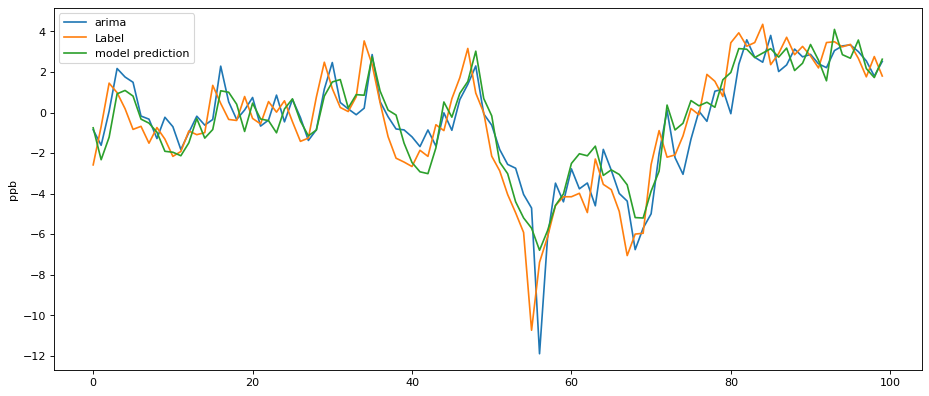

In [23]:
plot_size = len(y_arima)
yh_test_r = y_test.flatten()
yh_test_p = yh_test_r[:plot_size]
y_nn_p    = y_nn[:plot_size]

# ARIMA results
y_arima = np.array(y_arima).flatten()
naive = np.concatenate(([0],yh_test_p[:-1]))
fig = plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.arange(0, len(y_arima)), y_arima, label="arima")
plt.plot(np.arange(0, len(yh_test_p)), yh_test_p, label="Label")
plt.plot(np.arange(0, len(y_nn_p)), y_nn_p, label="model prediction")
# plt.plot(np.arange(0, len(y_nn_p)), naive, label="naive prediction")
plt.legend()
plt.ylabel("ppb")

# Holdover error
arima_err = y_arima - yh_test_p
y_nn_temp_err = y_nn_p - yh_test_p
naive_err = naive -  yh_test_p
# 100 step error
print("[ARIMA]   Variance: %6.2f Mean: %6.2f"%(np.var(arima_err), np.mean(arima_err)))
print("[ARIMA]   MAE:       %f " %mean_absolute_error(y_arima, yh_test_p))

print(
    "[NN] Variance: %6.2f Mean: %6.2f"
    % (np.var(y_nn_temp_err), np.mean(y_nn_temp_err))
)
print("[NN] MAE:       %f " % mean_absolute_error(y_nn_p, yh_test_p))

print(
    "[Naive] Variance: %6.2f Mean: %6.2f"
    % (np.var(naive_err), np.mean(naive_err))
)
print("[Naive] MAE:       %f " % mean_absolute_error(naive, yh_test_p))

## Now the invert differencing the time series

In [24]:
series = price
lag = 8
y_arima_p = y_arima
split_id    = i_train.max() + N + 1 + lag
past_period = series[split_id-lag:split_id]
y_nn_p[:lag]      = past_period + y_nn[:lag]
y_arima_p[:lag]   = past_period + y_arima[:lag]
yh_test_p[:lag]      = past_period +yh_test_p[:lag]
true_labels = series[split_id:split_id+pred_size]

for i in range(lag,pred_size):
    past_value = series[split_id-lag+i]
    y_nn_p[i]  = y_nn_p[i] + past_value
    y_arima_p[i] = y_arima_p[i] + past_value
    yh_test_r[i]   = yh_test_r[i] + past_value

[ARIMA]   Variance:   2.17 Mean:   0.12
[ARIMA]   MAE:       1.135042 
[NN] Variance:   1.66 Mean:   0.19
[NN] MAE:       1.027254 


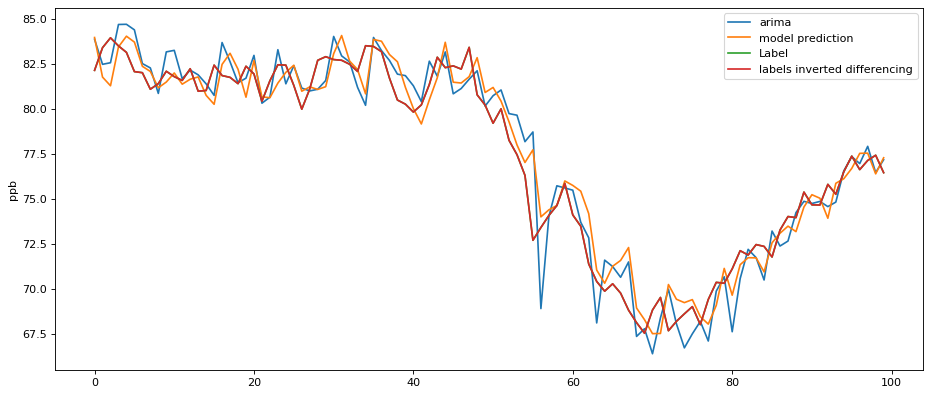

In [26]:
# ARIMA results
y_arima = np.array(y_arima).flatten()
naive = np.concatenate((yh_test_p[1:],[0]))
fig = plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.arange(0, len(y_arima_p)), y_arima_p, label="arima")
plt.plot(np.arange(0, len(y_nn_p)), y_nn_p, label="model prediction")
plt.plot(np.arange(0, len(true_labels)), true_labels, label="Label")
plt.plot(np.arange(0, len(yh_test_r[:pred_size])), yh_test_r[:pred_size], label="labels inverted differencing")
#plt.plot(np.arange(0, len(y_nn_p)), naive, label="naive prediction")
plt.legend()
plt.ylabel("ppb")

# Holdover error
arima_err = y_arima_p - true_labels
y_nn_temp_err = y_nn_p - true_labels


# 100 step error
print("[ARIMA]   Variance: %6.2f Mean: %6.2f"%(np.var(arima_err), np.mean(arima_err)))
print("[ARIMA]   MAE:       %f " %mean_absolute_error(y_arima_p, true_labels))

print(
    "[NN] Variance: %6.2f Mean: %6.2f"
    % (np.var(y_nn_temp_err), np.mean(y_nn_temp_err))
)
print("[NN] MAE:       %f " % mean_absolute_error(y_nn_p, true_labels))
